# 과제2 : 배송 성과 분석 및 지역별 물류 최적화 방안
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요.

In [10]:
# ============================================================
# 배송 성과 분석 & 지역별 물류 최적화 방안
# 1. 주문~배송 소요시간 분석
# 2. 지역별(주/권역) 배송 성과 차이 파악
# 3. 물류 최적화 방안 도출
# 4. 배송 지연이 리뷰 점수에 미치는 영향 분석
# ============================================================

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from matplotlib.patches import Patch

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.float_format = lambda x: f"{x:,.2f}"

#csv
customers = pd.read_csv('./olist_customers_dataset.csv')        # 고객
orders    = pd.read_csv('./olist_orders_dataset.csv')           # 주문
payments  = pd.read_csv('./olist_order_payments_dataset.csv')   # 결제
reviews   = pd.read_csv('./olist_order_reviews_dataset.csv')    # 리뷰
sellers   = pd.read_csv('./olist_sellers_dataset.csv')          # 셀러
items     = pd.read_csv('./olist_order_items_dataset.csv')      # 주문상품
products  = pd.read_csv('./olist_products_dataset.csv')         # 상품
geoloc    = pd.read_csv('./olist_geolocation_dataset.csv')      # 위치
category  = pd.read_csv('./product_category_name_translation.csv') # 카테고리

# 날짜 변환
dt_cols = [
    'order_purchase_timestamp','order_approved_at',
    'order_delivered_carrier_date','order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for c in dt_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')

# 이상치 완화용
def winsorize(series, low_q=0.01, high_q=0.99):
    ser = pd.to_numeric(series, errors='coerce')
    lo, hi = ser.quantile(low_q), ser.quantile(high_q)
    return ser.clip(lower=lo, upper=hi)

def winsorize_upper(series, high_q=0.99):
    ser = pd.to_numeric(series, errors='coerce')
    hi = ser.quantile(high_q)
    return ser.clip(upper=hi)

# 데이터 전처리
# (1) 배송일이 존재하는 주문만 사용
#  - status가 delivered가 아니더라도 배송일자가 있으면 포함하기
ship = orders[orders['order_delivered_customer_date'].notna()].copy()

# (2) 잘못된 주문 제거
#  - 구매일 > 배송일 : 제거
ship = ship[ship['order_purchase_timestamp'] <= ship['order_delivered_customer_date']].copy()

# (3) 기본 리드타임/지연 계산
ship['t_purchase_to_delivered'] = (
    ship['order_delivered_customer_date'] - ship['order_purchase_timestamp']
).dt.total_seconds()/86400

ship['delay_days'] = (
    ship['order_delivered_customer_date'] - ship['order_estimated_delivery_date']
).dt.total_seconds()/86400

# 리드타임 0~365일만, 지연은 -30~60일만
ship = ship[(ship['t_purchase_to_delivered'] > 0) & (ship['t_purchase_to_delivered'] < 365)].copy()
ship = ship[ship['delay_days'].between(-30, 60)].copy() 

# (4) 리뷰 전처리
#  - 리뷰 스코어 결측 제거
rev = reviews[['order_id','review_score','review_creation_date']].dropna(subset=['review_score']).copy()
rev['review_creation_date'] = pd.to_datetime(rev['review_creation_date'], errors='coerce')
#  - 리뷰가 배송일 이후 작성된 경우만 유지
rev = rev.merge(ship[['order_id','order_delivered_customer_date']], on='order_id', how='inner')
rev = rev[rev['review_creation_date'] >= rev['order_delivered_customer_date']].copy()

# (5) 배송비 전처리
items = items[items['freight_value'] >= 0].copy()  # 음수 제거
items['freight_value'] = winsorize_upper(items['freight_value'], 0.99)  # 상단 1% 캡, 0은 유지

# 고객/판매자 지역 정보 병합 및 지역 매핑
# =========================
ship = ship.merge(
    customers[['customer_id','customer_unique_id','customer_state']],
    on='customer_id', how='left'
)

items_seller = items.merge(
    sellers[['seller_id','seller_state']],
    on='seller_id', how='left'
)

uf_to_region = {
    # North
    "AC":"North","AP":"North","AM":"North","PA":"North","RO":"North","RR":"North","TO":"North",
    # Northeast
    "AL":"Northeast","BA":"Northeast","CE":"Northeast","MA":"Northeast","PB":"Northeast",
    "PE":"Northeast","PI":"Northeast","RN":"Northeast","SE":"Northeast",
    # Central-West
    "DF":"Central-West","GO":"Central-West","MT":"Central-West","MS":"Central-West",
    # Southeast
    "ES":"Southeast","MG":"Southeast","RJ":"Southeast","SP":"Southeast",
    # South
    "PR":"South","RS":"South","SC":"South"
}
ship['customer_region'] = ship['customer_state'].map(uf_to_region)
sellers['seller_region'] = sellers['seller_state'].map(uf_to_region)

# 고정 색상 팔레트(지역별)✅
REGION_COLORS = {
    'North':        'blue',
    'Northeast':    'orange',
    'Central-West': 'green',
    'Southeast':    'red',
    'South':        'purple',
    None:           'gray'
}

def add_region_legend(ax, regions):
    uniq = []
    for r in regions:
        if (r not in uniq) and (pd.notna(r)):
            uniq.append(r)
    handles = [Patch(color=REGION_COLORS.get(r, REGION_COLORS[None]), label=str(r)) for r in uniq]
    if handles:
        ax.legend(handles=handles, title="Region", frameon=False, loc='best')


=== (1) 전체 리드타임/지연 요약 ===
  주문수  리드타임_평균(일)  리드타임_중위(일)  리드타임_p90(일)  지연_평균(일)  정시율(%)
94037       12.40       10.24        23.14    -10.73   91.77


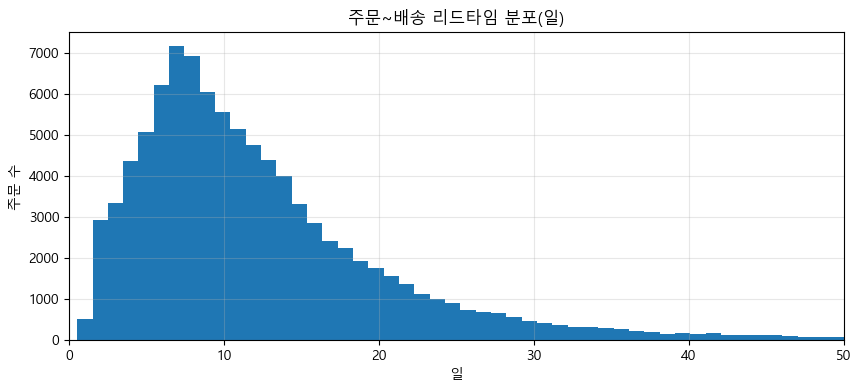

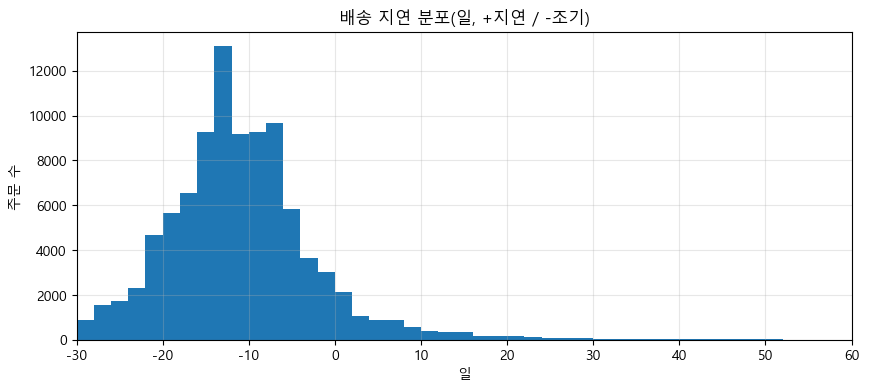

In [12]:
# 1) 주문~배송 리드타임 & 지연
# --------------------------

# 구간별 소요시간(일)
ship['t_purchase_to_approved'] = (ship['order_approved_at'] - ship['order_purchase_timestamp']).dt.total_seconds()/86400
ship['t_approved_to_carrier']  = (ship['order_delivered_carrier_date'] - ship['order_approved_at']).dt.total_seconds()/86400
ship['t_carrier_to_customer']  = (ship['order_delivered_customer_date'] - ship['order_delivered_carrier_date']).dt.total_seconds()/86400
ship['t_purchase_to_estimated']= (ship['order_estimated_delivery_date'] - ship['order_purchase_timestamp']).dt.total_seconds()/86400

# 분석 안정화용 winsorize (1~99%)
ship['t_purchase_to_delivered_w'] = winsorize(ship['t_purchase_to_delivered'], 0.01, 0.99)
ship['delay_days_w'] = winsorize(ship['delay_days'], 0.01, 0.99)

def pct(s, q): 
    return np.nanpercentile(s, q)

summary_overall = pd.DataFrame({
    '주문수':[ship['order_id'].nunique()],
    '리드타임_평균(일)':[ship['t_purchase_to_delivered_w'].mean()],
    '리드타임_중위(일)':[ship['t_purchase_to_delivered_w'].median()],
    '리드타임_p90(일)':[pct(ship['t_purchase_to_delivered_w'],90)],
    '지연_평균(일)':[ship['delay_days_w'].mean()],
    '정시율(%)':[(ship['delay_days']<=0).mean()*100]
}).round(2)

print("\n=== (1) 전체 리드타임/지연 요약 ===")
print(summary_overall.to_string(index=False))

# 분포 시각화
plt.figure(figsize=(10,4))
vals = ship['t_purchase_to_delivered'].dropna()
vals = vals[(vals >= 0) & (vals < 50)] 
plt.hist(vals, bins=50, color='tab:blue')
plt.title("주문~배송 리드타임 분포(일)")
plt.xlabel("일"); plt.ylabel("주문 수")
plt.xlim(0, 50); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(10,4))
dvals = ship['delay_days'].dropna()
dvals = dvals[(dvals >= -30) & (dvals <= 60)]       
bins = np.arange(-30, 61, 2)                               
plt.hist(dvals, bins=bins, label='지연일수')  
plt.title("배송 지연 분포(일, +지연 / -조기)")
plt.xlabel("일"); plt.ylabel("주문 수")
plt.xlim(-30, 60); plt.grid(alpha=0.3)                      
plt.show()


=== (2) 주(State) 단위 성과 (상위 10개: 정시율 우수) ===
customer_state customer_region   주문수  리드타임_평균  리드타임_중위   p90  지연_평균   정시율
            RO           North   223    19.62    18.01 29.77 -17.82 96.86
            AP           North    55    25.92    26.16 34.83 -18.62 96.36
            AM           North   116    28.01    27.32 39.68 -15.27 95.69
            AC           North    64    21.82    20.06 33.89 -16.71 95.31
            PR           South  4814    11.98    10.49 20.16 -12.16 94.93
            MG       Southeast 11115    11.99    10.36 20.28 -12.10 94.29
            SP       Southeast 39953     8.67     7.20 15.72 -10.13 94.09
            MT    Central-West   852    18.10    16.16 27.96 -12.85 92.96
            DF    Central-West  2039    13.00    11.58 21.82 -10.88 92.79
            RS           South  5170    15.26    13.25 26.07 -12.55 92.65

=== (2) 지역별(Region) 단위 성과 ===
customer_region   주문수  리드타임_평균  리드타임_중위   p90  지연_평균   정시율
      Southeast 64703    10.63     8.72 19.67 -10.4

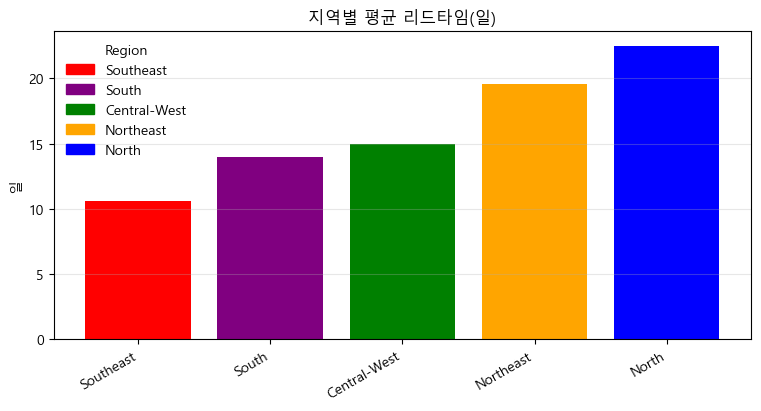

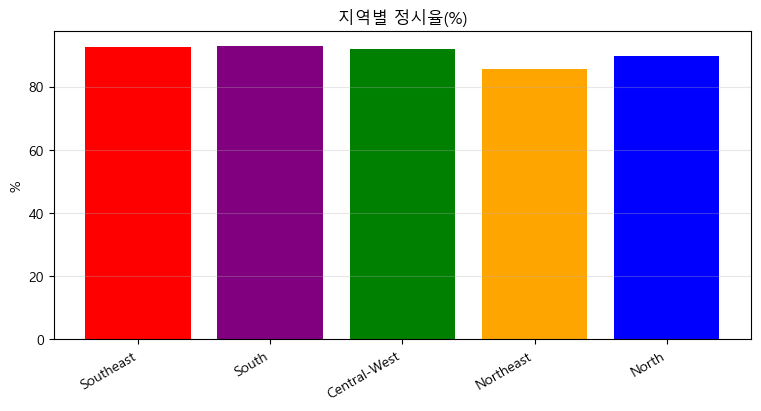


[북부 주 진단: 정시율/지연율/리드타임]
customer_state  주문수   정시율  리드타임_평균  지연_평균  지연율(%)
            RO  223 96.86    19.62 -17.82    3.14
            AP   55 96.36    25.92 -18.62    3.64
            AM  116 95.69    28.01 -15.27    4.31
            AC   64 95.31    21.82 -16.71    4.69
            PA  885 87.01    23.57 -12.32   12.99
            TO  267 86.89    17.67 -10.72   13.11
            RR   28 85.71    28.36 -12.20   14.29

[지각 주문 기준 평균 지연(+일) 추가]
customer_state  주문수   정시율  지연율(%)  리드타임_평균  지연_평균  지연_평균_지각만
            RO  223 96.86    3.14    19.62 -17.82       6.18
            AP   55 96.36    3.64    25.92 -18.62       0.95
            AM  116 95.69    4.31    28.01 -15.27       4.14
            AC   64 95.31    4.69    21.82 -16.71      19.03
            PA  885 87.01   12.99    23.57 -12.32      10.55
            TO  267 86.89   13.11    17.67 -10.72       5.65
            RR   28 85.71   14.29    28.36 -12.20      13.17

[정시율 Top10 (주문수 >= 1000)]
customer_state   주문수   정시율  리드타임_평균

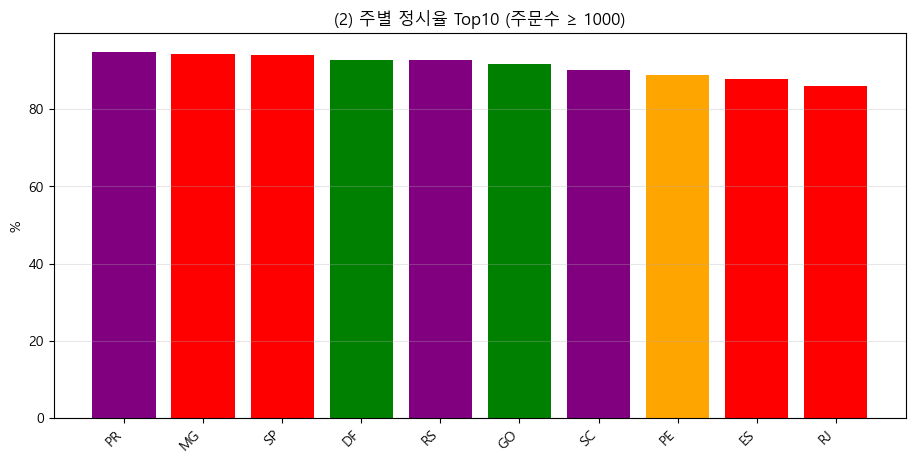

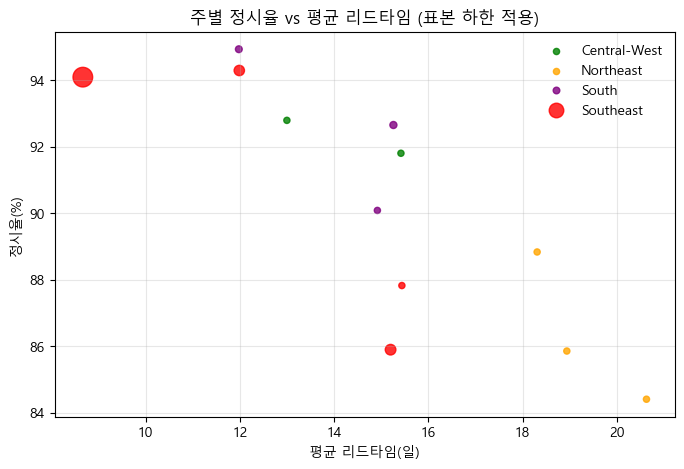

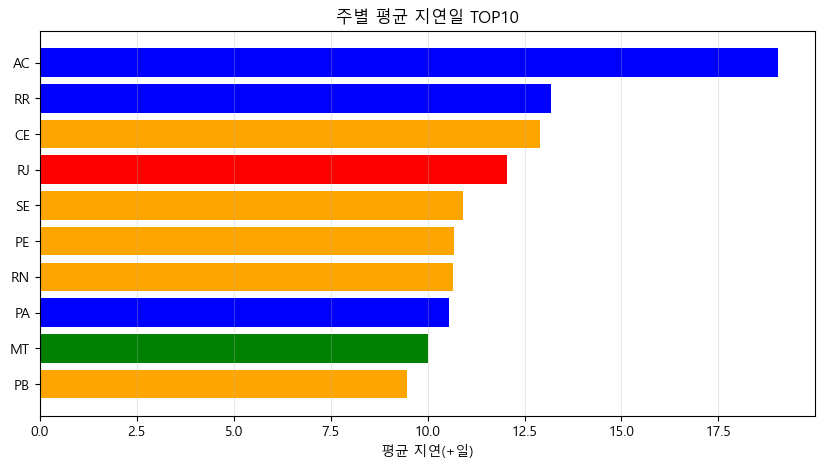


=== (2) 판매자주 → 고객주 코리도어 성과 (TOP 10: 정시율 우수) ===
seller_state customer_state  주문수  리드타임_평균  지연_평균    정시율
          PI             PI    1     2.03 -14.06 100.00
          PA             PR    1     3.46 -14.10 100.00
          RN             MG    1     3.56 -12.02 100.00
          RN             RN   21     4.76 -14.87 100.00
          PI             MA    1     5.84 -13.29 100.00
          CE             CE    8     6.08 -13.70 100.00
          PB             PE    2     6.72 -18.72 100.00
          PB             CE    2     7.51 -26.22 100.00
          RO             PR    1     7.96 -23.47 100.00
          PB             GO    1     8.02 -12.10 100.00


In [ ]:
# 2) 지역별 배송 성과 (State/Region)
# ---------------------------------

if 't_purchase_to_delivered_w' not in ship.columns:
    ship['t_purchase_to_delivered_w'] = winsorize(ship['t_purchase_to_delivered'], 0.01, 0.99)
if 'delay_days_w' not in ship.columns:
    ship['delay_days_w'] = winsorize(ship['delay_days'], 0.01, 0.99)

STATE_AGG = {
    '주문수':       ('order_id', 'nunique'),
    '리드타임_평균': ('t_purchase_to_delivered_w', 'mean'),
    '리드타임_중위': ('t_purchase_to_delivered_w', 'median'),
    'p90':         ('t_purchase_to_delivered_w', lambda s: np.nanpercentile(s, 90)),
    '지연_평균':     ('delay_days_w', 'mean'),
    '정시율':       ('delay_days', lambda s: (s <= 0).mean() * 100),
}

by_state = (ship
    .groupby(['customer_state', 'customer_region'], dropna=False) 
    .agg(**STATE_AGG)                                             
    .reset_index()
    .sort_values(['정시율', '리드타임_평균'], ascending=[False, True])
).round(2)

print("\n=== (2) 주(State) 단위 성과 (상위 10개: 정시율 우수) ===")
print(by_state.head(10).to_string(index=False))

by_region = (ship
    .groupby('customer_region', dropna=False)
    .agg(주문수=('order_id','nunique'),
         리드타임_평균=('t_purchase_to_delivered_w','mean'),
         리드타임_중위=('t_purchase_to_delivered_w','median'),
         p90=('t_purchase_to_delivered_w', lambda s: pct(s,90)),
         지연_평균=('delay_days_w','mean'),
         정시율=('delay_days', lambda s: (s<=0).mean()*100))
    .reset_index()
    .sort_values('리드타임_평균')
).round(2)

print("\n=== (2) 지역별(Region) 단위 성과 ===")
print(by_region.to_string(index=False))

# 시각화
plt.figure(figsize=(9,4))
colors = [REGION_COLORS.get(r, REGION_COLORS[None]) for r in by_region['customer_region']]
plt.bar(by_region['customer_region'].astype(str), by_region['리드타임_평균'], color=colors)
plt.title("지역별 평균 리드타임(일)")
plt.xticks(rotation=30, ha='right')
plt.ylabel("일")
plt.grid(axis='y', alpha=0.3)
add_region_legend(plt.gca(), by_region['customer_region'].tolist())
plt.show()

plt.figure(figsize=(9,4))
colors = [REGION_COLORS.get(r, REGION_COLORS[None]) for r in by_region['customer_region']]
plt.bar(by_region['customer_region'].astype(str), by_region['정시율'], color=colors)
plt.title("지역별 정시율(%)")
plt.xticks(rotation=30, ha='right')
plt.ylabel("%")
plt.grid(axis='y', alpha=0.3)
plt.show()

state_perf = (
    ship.groupby(['customer_state','customer_region'], dropna=False)
        .agg(
            지연_평균_지각만 = ('delay_days', lambda s: s[s > 0].mean()),
            지연_p90_지각만 = ('delay_days', lambda s: np.nanpercentile(s[s > 0], 90) if (s > 0).any() else np.nan)
        )
        .reset_index()
)

# late State TOP10 (평균 지연 하위)

# 북부 주요 주만 진단
north_states = ['RO','AP','AM','AC','PA','RR','TO']  # 필요하면 추가
cols = ['customer_state','주문수','정시율','리드타임_평균','지연_평균']
chk = by_state[by_state['customer_state'].isin(north_states)][cols].sort_values('정시율', ascending=False)
chk['지연율(%)'] = 100 - chk['정시율']
print("\n[북부 주 진단: 정시율/지연율/리드타임]")
print(chk.to_string(index=False))

if 'state_perf' in globals() and '지연_평균_지각만' in state_perf.columns:
    tmp = chk.merge(state_perf[['customer_state','지연_평균_지각만']], on='customer_state', how='left')
    print("\n[지각 주문 기준 평균 지연(+일) 추가]")
    print(tmp[['customer_state','주문수','정시율','지연율(%)','리드타임_평균','지연_평균','지연_평균_지각만']].to_string(index=False))

# 2) 순위 왜곡 줄이기: 최소 표본수 필터 후 Top10 재구성
MIN_ORDERS = 1000  # 표본 하한, 데이터 규모에 맞게 조절
by_state_f = by_state[by_state['주문수'] >= MIN_ORDERS].copy()

top10_ontime = by_state_f.sort_values('정시율', ascending=False).head(10)
print("\n[정시율 Top10 (주문수 >= {0})]".format(MIN_ORDERS))
print(top10_ontime[['customer_state','주문수','정시율','리드타임_평균','지연_평균']].to_string(index=False))

# 시각화도 표본 하한 반영
plt.figure(figsize=(11,5))
colors = [REGION_COLORS.get(r, REGION_COLORS[None]) for r in top10_ontime['customer_region']]
plt.bar(top10_ontime['customer_state'].astype(str), top10_ontime['정시율'], color=colors)
plt.title(f"주별 정시율 Top10 (주문수 ≥ {MIN_ORDERS})")
plt.xticks(rotation=45, ha='right'); plt.ylabel("%"); plt.grid(axis='y', alpha=0.3)
plt.show()

# 3) 정시율 vs 리드타임 같이 보기(같은 주라도 '리드타임 길고 정시율 높은' 케이스 확인)
plt.figure(figsize=(8,5))
for rg in sorted(by_state_f['customer_region'].dropna().unique()):
    sub = by_state_f[by_state_f['customer_region']==rg]
    plt.scatter(sub['리드타임_평균'], sub['정시율'],
                s=np.clip(sub['주문수']/200, 20, 200),  # 주문수로 점 크기 가중
                alpha=0.8, label=rg, color=REGION_COLORS.get(rg, REGION_COLORS[None]))
plt.xlabel("평균 리드타임(일)"); plt.ylabel("정시율(%)")
plt.title("주별 정시율 vs 평균 리드타임 (표본 하한 적용)")
plt.grid(alpha=0.3); plt.legend(frameon=False); plt.show()


late_worst = (
    state_perf
        .dropna(subset=['지연_평균_지각만'])
        .sort_values('지연_평균_지각만', ascending=False)
        .head(10)
)

plt.figure(figsize=(10,5))
colors = [REGION_COLORS.get(r, REGION_COLORS[None]) for r in late_worst['customer_region']]
plt.barh(late_worst['customer_state'].astype(str), late_worst['지연_평균_지각만'], color=colors)
plt.title("주별 평균 지연일 TOP10")
plt.xlabel("평균 지연(+일)")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.show()


# 판매자주 → 고객주 코리도어 성과 (아이템 단위)
item_order = items_seller.merge(
    ship[['order_id','customer_state','customer_region',
          'order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']],
    on='order_id', how='inner'
)
item_order['t_purchase_to_delivered'] = (item_order['order_delivered_customer_date'] - item_order['order_purchase_timestamp']).dt.total_seconds()/86400
item_order['delay_days'] = (item_order['order_delivered_customer_date'] - item_order['order_estimated_delivery_date']).dt.total_seconds()/86400
item_order['t_purchase_to_delivered_w'] = winsorize(item_order['t_purchase_to_delivered'], 0.01, 0.99)
item_order['delay_days_w'] = winsorize(item_order['delay_days'], 0.01, 0.99)

corridor = (item_order
    .groupby(['seller_state','customer_state'], dropna=False)
    .agg(주문수=('order_id','nunique'),
         리드타임_평균=('t_purchase_to_delivered_w','mean'),
         지연_평균=('delay_days_w','mean'),
         정시율=('delay_days', lambda s: (s<=0).mean()*100))
    .reset_index()
    .sort_values(['정시율','리드타임_평균'], ascending=[False, True])
).round(2)
print("\n=== (2) 판매자주 → 고객주 코리도어 성과 (TOP 10: 정시율 우수) ===")
print(corridor.head(10).to_string(index=False))

In [14]:
# 3) 물류 최적화 방안
# ------------------

slow_regions = by_region.sort_values('리드타임_평균', ascending=False).head(3)
risk_states  = by_state.sort_values('정시율').head(5)      # 정시율 낮은 주
slow_corr    = corridor.sort_values(['정시율','리드타임_평균'], ascending=[True, False]).head(5)

print("\n=== (3) 물류 최적화 제언 (데이터 기반 쉬운 문구) ===")
print("- 리드타임이 상대적으로 긴 권역 Top3:")
for _, r in slow_regions.iterrows():
    print(f"  • {r['customer_region']}: 평균 {r['리드타임_평균']:.2f}일, p90 {r['p90']:.2f}일, 정시율 {r['정시율']:.1f}%")

print("- 정시율이 낮은 주(개선 우선순위) Top5:")
for _, r in risk_states.iterrows():
    print(f"  • {r['customer_state']}: 정시율 {r['정시율']:.1f}%, 지연평균 {r['지연_평균']:.2f}일")

print("- 지연 성과가 나쁜 코리도어 Top5:")
for _, r in slow_corr.iterrows():
    print(f"  • {r['seller_state']} → {r['customer_state']}: 정시율 {r['정시율']:.1f}%, 리드타임평균 {r['리드타임_평균']:.2f}일, 지연평균 {r['지연_평균']:.2f}일")

def easy_action_guide_no_infra(by_state_df, sim_state_df=None):
    # 상·하위 주 추출
    top_states = by_state_df.sort_values('정시율', ascending=False).head(3)['customer_state'].tolist()  
    low_states = by_state_df.sort_values('정시율').head(3)['customer_state'].tolist()                   

    # (선택) 할인 시뮬 결과가 있으면 괄호로 덧붙임
    uplift_map = {}
    if (sim_state_df is not None) and {'customer_state','orders_uplift_%'}.issubset(sim_state_df.columns):
        uplift_map = sim_state_df.set_index('customer_state')['orders_uplift_%'].to_dict()              

    def fmt_uplift(states):
        vals = [f"{s} +{uplift_map[s]:.1f}%" for s in states if s in uplift_map]
        return f" (할인 시 예상 주문↑: {', '.join(vals)})" if vals else ""                             

    lines = []
    lines.append("\n물류 최적화 핵심 4가지")
    lines.append("")
    lines.append(f"정시율 높은 주 (유지/확산)  — 예: {', '.join(top_states)}")
    lines.append("• 운영 방식 표준화·확산: 상위 지역의 택배사 조합·마감시간·배송 동선을 다른 지역에도 적용")
    lines.append("• 약속일(EDD) 살짝 당김: 0.5~1일 앞당겨 노출, 빠른배송 옵션 함께 제시")
    lines.append("")
    lines.append(f"정시율 낮은 주 (개선/수요 견인) — 예: {', '.join(low_states)}" + fmt_uplift(low_states))
    lines.append("• 배송비 차등 할인: 느린 지역만 약 10% 인하 → 가격 장벽 완화로 주문 증가 유도")
    lines.append("• 느린 구간 바로잡기: 출고 대기·이동·배달 단계의 병목 찾아 마감시간 조정·픽업 간격 단축·동선 재조정")
    return "\n".join(lines)

print(easy_action_guide_no_infra(by_state, sim_state if 'sim_state' in globals() else None))


=== (3) 물류 최적화 제언 (데이터 기반 쉬운 문구) ===
- 리드타임이 상대적으로 긴 권역 Top3:
  • North: 평균 22.48일, p90 37.03일, 정시율 89.6%
  • Northeast: 평균 19.61일, p90 33.17일, 정시율 85.4%
  • Central-West: 평균 14.96일, p90 24.29일, 정시율 91.9%
- 정시율이 낮은 주(개선 우선순위) Top5:
  • AL: 정시율 75.4%, 지연평균 -7.36일
  • MA: 정시율 79.9%, 지연평균 -8.30일
  • PI: 정시율 83.8%, 지연평균 -10.71일
  • CE: 정시율 84.4%, 지연평균 -9.99일
  • SE: 정시율 84.7%, 지연평균 -9.51일
- 지연 성과가 나쁜 코리도어 Top5:
  • AM → AL: 정시율 0.0%, 리드타임평균 45.19일, 지연평균 17.87일
  • BA → AC: 정시율 0.0%, 리드타임평균 45.19일, 지연평균 17.87일
  • PB → AL: 정시율 0.0%, 리드타임평균 31.10일, 지연평균 0.81일
  • AM → MA: 정시율 0.0%, 리드타임평균 29.52일, 지연평균 0.39일
  • MA → AL: 정시율 25.0%, 리드타임평균 30.18일, 지연평균 1.58일

물류 최적화 핵심 4가지

정시율 높은 주 (유지/확산)  — 예: RO, AP, AM
• 운영 방식 표준화·확산: 상위 지역의 택배사 조합·마감시간·배송 동선을 다른 지역에도 적용
• 약속일(EDD) 살짝 당김: 0.5~1일 앞당겨 노출, 빠른배송 옵션 함께 제시

정시율 낮은 주 (개선/수요 견인) — 예: AL, MA, PI
• 배송비 차등 할인: 느린 지역만 약 10% 인하 → 가격 장벽 완화로 주문 증가 유도
• 느린 구간 바로잡기: 출고 대기·이동·배달 단계의 병목 찾아 마감시간 조정·픽업 간격 단축·동선 재조정



=== (4) 리뷰 점수와의 상관(피어슨) ===


,상관계수
delay_days,-0.30
t_purchase_to_delivered,-0.35
review_score,1.00


C:\Users\samsung\AppData\Local\Temp\ipykernel_23568\1977067113.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('delay_bucket')


=== (4) 지연 버킷별 리뷰 점수 ===


,delay_bucket,리뷰수,평균점수,중위점수
0,조기(-2일↑),83297,4.30,5.00
1,정시(≤0),3005,4.14,5.00
2,지연(0~3일),2651,3.77,4.00
3,지연(3~7일),1777,2.32,1.00
4,지연(7일+),3193,1.70,1.00


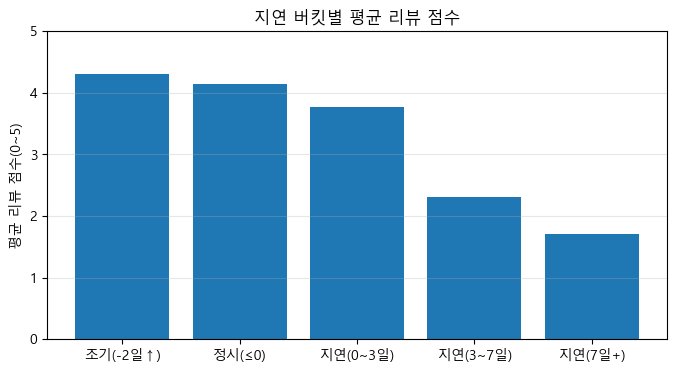

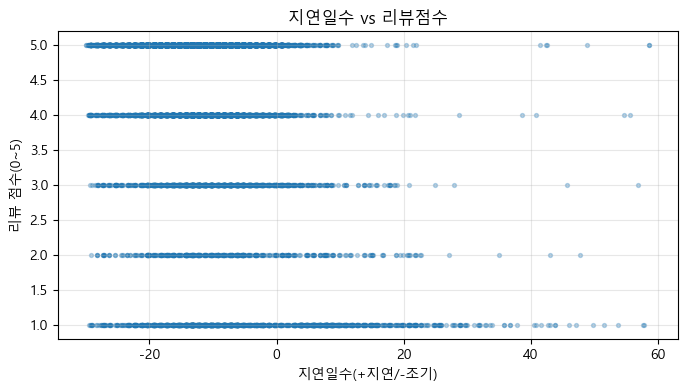


=== 요약 ===
- 전체 평균 리드타임: 12.40일, 정시율: 91.8%
- 권역 중 느린 곳(Top1): North / 평균 22.48일
- 정시율이 낮은 주(Top1): AL / 정시율 75.4%
- 리뷰 점수와 지연의 상관(음수일수록 만족↑, 양수일수록 만족↓ 경향) 및 버킷별 점수 차이를 확인하세요.


In [15]:
# 4) 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향
# ------------------------------------------------

rev = reviews[['order_id','review_score','review_creation_date']].copy()
rev['review_creation_date'] = pd.to_datetime(rev['review_creation_date'], errors='coerce')

ship_rev = ship.merge(rev, on='order_id', how='left')
ship_rev = ship_rev[ship_rev['review_score'].notna()].copy()

# 단순 상관 / 집단 비교
corr = ship_rev[['delay_days','t_purchase_to_delivered','review_score']].corr().loc['review_score']
print("\n=== (4) 리뷰 점수와의 상관(피어슨) ===")
display(corr.to_frame('상관계수').round(3))

# 지연 버킷 생성
bins = [-999, -2, 0, 3, 7, 999]  # 조기/정시/경미지연/중간/중대
labels = ['조기(-2일↑)','정시(≤0)','지연(0~3일)','지연(3~7일)','지연(7일+)']
ship_rev['delay_bucket'] = pd.cut(ship_rev['delay_days'], bins=bins, labels=labels, include_lowest=True)

bucket_score = (ship_rev
    .groupby('delay_bucket')
    .agg(리뷰수=('review_score','count'),
         평균점수=('review_score','mean'),
         중위점수=('review_score','median'))
    .reset_index()
)
print("=== (4) 지연 버킷별 리뷰 점수 ===")
display(bucket_score.round(2))

# 시각화: 버킷별 평균 리뷰 점수
plt.figure(figsize=(8,4))
plt.bar(bucket_score['delay_bucket'].astype(str), bucket_score['평균점수'])
plt.title("지연 버킷별 평균 리뷰 점수")
plt.ylim(0,5); plt.ylabel("평균 리뷰 점수(0~5)")
plt.grid(axis='y', alpha=0.3); plt.show()

# 시각화: 지연일수 vs 리뷰점수 산포(표본)
sample = ship_rev.sample(min(15000, len(ship_rev)), random_state=42)
plt.figure(figsize=(8,4))
plt.scatter(sample['delay_days'], sample['review_score'], s=8, alpha=0.3)
plt.title("지연일수 vs 리뷰점수")
plt.xlabel("지연일수(+지연/-조기)"); plt.ylabel("리뷰 점수(0~5)")
plt.grid(alpha=0.3); plt.show()

# ---------------
# 간단 요약 프린트
# ---------------
print("\n=== 요약 ===")
print(f"- 전체 평균 리드타임: {summary_overall['리드타임_평균(일)'].iloc[0]:.2f}일, 정시율: {summary_overall['정시율(%)'].iloc[0]:.1f}%")
print(f"- 권역 중 느린 곳(Top1): {slow_regions.iloc[0]['customer_region']} / 평균 {slow_regions.iloc[0]['리드타임_평균']:.2f}일")
print(f"- 정시율이 낮은 주(Top1): {risk_states.iloc[0]['customer_state']} / 정시율 {risk_states.iloc[0]['정시율']:.1f}%")
print("- 리뷰 점수와 지연의 상관(음수일수록 만족↑, 양수일수록 만족↓ 경향) 및 버킷별 점수 차이를 확인하세요.")

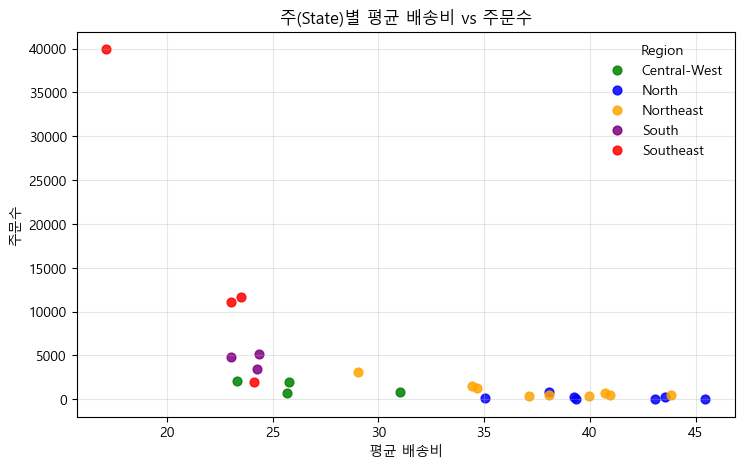

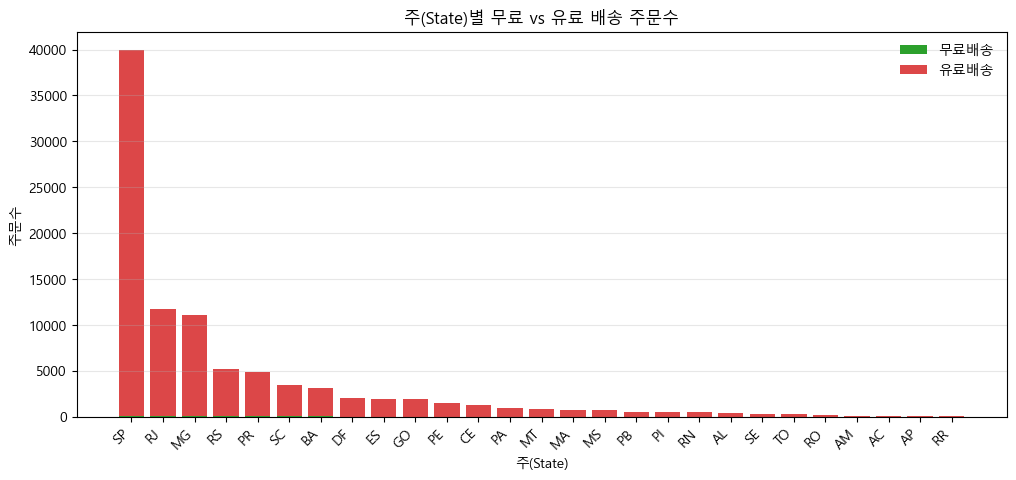


=== 무료배송 시행 셀러의 월평균 주문/매출 변화율(시행월 vs 비시행월) ===
                       seller_id  orders_uplift_%  revenue_uplift_%
1f50f920176fa81dab994f9023523100            18.60             80.80
37be5a7c751166fbc5f8ccba4119e043           265.50            270.10
4869f7a5dfa277a7dca6462dcf3b52b2            71.60             31.30
7d13fca15225358621be4086e1eb0964           209.70            150.90
8581055ce74af1daba164fdbd55a40de           -16.20            -32.60
955fee9216a65b617aa5c0531780ce60           110.80            227.10
c826c40d7b19f62a09e2d7c5e7295ee2             2.20              1.40
cc419e0650a3c5ba77189a1882b7556a           -70.60            -68.10

=== 리뷰 점수: 무료배송 vs 유료배송 ===
무료배송 평균 리뷰: 4.380 / 유료배송 평균 리뷰: 4.153 / 차이: +0.226p


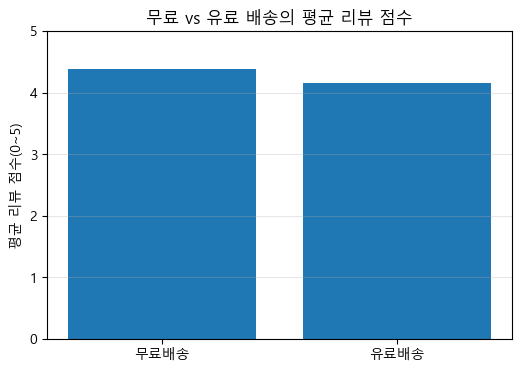

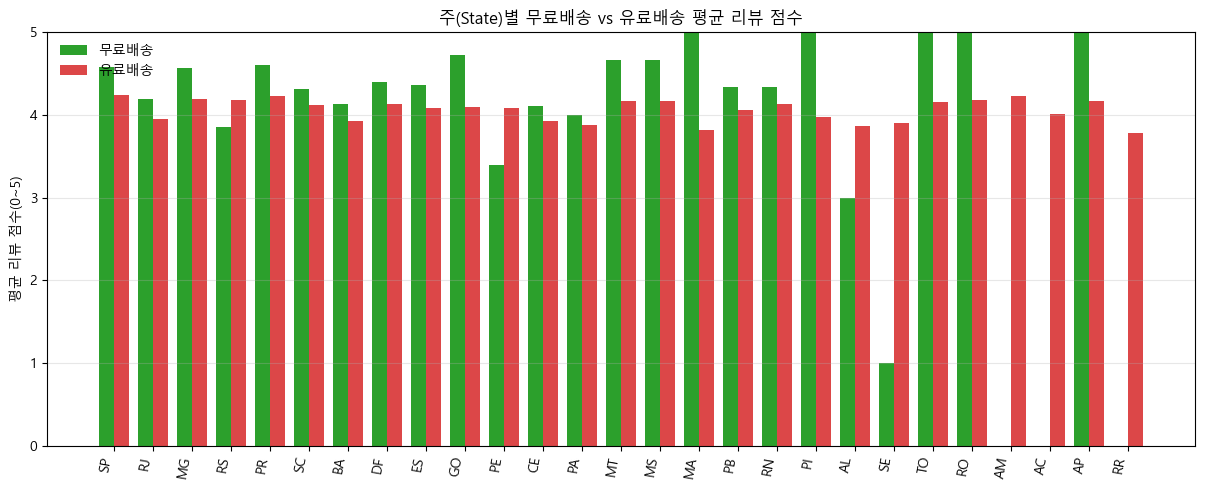

In [17]:
# 5) 배송비 차등 정책 분석
# ----------------------

# 주문 단위 집계: 배송비/매출/지역/월
order_costs = (items
    .groupby('order_id', as_index=False)
    .agg(order_freight=('freight_value','sum'),
         order_revenue=('price','sum'),
         sellers_in_order=('seller_id','nunique'))
)

# '배송일 존재' 주문으로 제한(상단 ship과 일관)
deliv = ship[['order_id','customer_id','customer_state','customer_region','order_purchase_timestamp']].copy()
deliv = deliv.merge(order_costs, on='order_id', how='left')
deliv['month'] = pd.to_datetime(deliv['order_purchase_timestamp']).dt.to_period('M').astype(str)

# 무료배송 여부(주문 단위) — 상단 캡 이후에도 0은 유지됨
deliv['is_free_ship'] = (deliv['order_freight'] == 0).astype(int)

# 주별 집계 만들기: 주문수/평균 배송비/매출
if 'state_agg' not in globals():
    state_agg = (deliv
        .groupby('customer_state', as_index=False)
        .agg(orders=('order_id','nunique'),
             avg_freight=('order_freight','mean'),
             revenue=('order_revenue','sum'))
    )

# 주(State)별: 평균 배송비 vs 주문수 (음의 상관 검증) ----------
state_region_map = (ship[['customer_state','customer_region']]
                    .drop_duplicates()
                    .set_index('customer_state')['customer_region']) 

# 매핑 적용: state_agg에 권역 컬럼 생성/덮어쓰기
state_agg['customer_region'] = state_agg['customer_state'].map(state_region_map)

plt.figure(figsize=(8.5,5))
for rg in sorted(state_agg['customer_region'].dropna().unique()):
    sub = state_agg[state_agg['customer_region'] == rg]
    plt.scatter(sub['avg_freight'], sub['orders'],
                s=40, alpha=0.85,
                color=REGION_COLORS.get(rg, REGION_COLORS[None]),
                label=str(rg)) 

plt.title("주(State)별 평균 배송비 vs 주문수")
plt.xlabel("평균 배송비")
plt.ylabel("주문수")
plt.grid(alpha=0.3)
plt.legend(frameon=False, title="Region") 
plt.show()

# 무료배송 효과: 주문/매출/리뷰
state_free = (deliv
    .groupby('customer_state', as_index=False)
    .agg(
        free_orders=('is_free_ship', 'sum'),
        total_orders=('order_id', 'nunique')
    )
    .dropna(subset=['customer_state'])
)
state_free['nonfree_orders'] = state_free['total_orders'] - state_free['free_orders']

# 주문 많은 순으로 정렬
state_free = state_free.sort_values('total_orders', ascending=False)

plt.figure(figsize=(12,5))
plt.bar(state_free['customer_state'], state_free['free_orders'],
        label='무료배송', color='tab:green')
plt.bar(state_free['customer_state'], state_free['nonfree_orders'],
        bottom=state_free['free_orders'],
        label='유료배송', color='tab:red', alpha=0.85)
plt.title("주(State)별 무료 vs 유료 배송 주문수")
plt.xlabel("주(State)")
plt.ylabel("주문수")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(frameon=False) 
plt.show()

# 셀러 레벨: 무료배송 시행 월 vs 비시행 월 비교
oi = items[['order_id','seller_id','freight_value']].merge(
    deliv[['order_id','month','order_revenue']], on='order_id', how='inner'
)
order_free_flag = deliv[['order_id','is_free_ship']]

seller_month = (oi
    .groupby(['seller_id','order_id','month'], as_index=False)
    .agg(order_freight=('freight_value','sum'),
         order_rev=('order_revenue','sum'))
    .merge(order_free_flag, on='order_id', how='left')
)
seller_month_agg = (seller_month
    .groupby(['seller_id','month'], as_index=False)
    .agg(orders=('order_id','nunique'),
         revenue=('order_rev','sum'),
         free_share=('is_free_ship','mean'))
)

has_free = seller_month_agg.groupby('seller_id')['free_share'].max().reset_index()
has_free = has_free[has_free['free_share']>0]['seller_id'].tolist()

effect_rows = seller_month_agg[seller_month_agg['seller_id'].isin(has_free)].copy()
effect_rows['is_free_month'] = (effect_rows['free_share']>0).astype(int)

seller_effect = (effect_rows
    .groupby(['seller_id','is_free_month'], as_index=False)
    .agg(months=('month','nunique'),
         avg_orders=('orders','mean'),
         avg_revenue=('revenue','mean'))
    .pivot(index='seller_id', columns='is_free_month', values=['avg_orders','avg_revenue'])
)
seller_effect.columns = ['avg_orders_nonfree','avg_orders_free','avg_rev_nonfree','avg_rev_free']
seller_effect = seller_effect.reset_index()

for a,b,out in [('avg_orders_free','avg_orders_nonfree','orders_uplift_%'),
                ('avg_rev_free','avg_rev_nonfree','revenue_uplift_%')]:
    seller_effect[out] = (seller_effect[a] - seller_effect[b]) / seller_effect[b] * 100

print("\n=== 무료배송 시행 셀러의 월평균 주문/매출 변화율(시행월 vs 비시행월) ===")
print(seller_effect[['seller_id','orders_uplift_%','revenue_uplift_%']].head(10).round(1).to_string(index=False))

# 리뷰: 무료배송 vs 유료배송 (전처리된 rev 사용)
free_review = deliv[['order_id','is_free_ship']].merge(
    rev[['order_id','review_score']], on='order_id', how='inner'
)
avg_review_free  = free_review.loc[free_review['is_free_ship']==1, 'review_score'].mean()
avg_review_paid  = free_review.loc[free_review['is_free_ship']==0, 'review_score'].mean()
diff_review      = avg_review_free - avg_review_paid

print("\n=== 리뷰 점수: 무료배송 vs 유료배송 ===")
print(f"무료배송 평균 리뷰: {avg_review_free:.3f} / 유료배송 평균 리뷰: {avg_review_paid:.3f} / 차이: {diff_review:+.3f}p")

plt.figure(figsize=(6,4))
plt.bar(['무료배송','유료배송'], [avg_review_free, avg_review_paid])
plt.ylim(0,5); plt.ylabel("평균 리뷰 점수(0~5)")
plt.title("무료 vs 유료 배송의 평균 리뷰 점수")
plt.grid(axis='y', alpha=0.3)
plt.show()


# 주별 무료배송 vs 유료배송 평균 리뷰 점수

# 주문-주/무료여부 정보에 리뷰 점수 결합
state_review = deliv[['order_id','customer_state','is_free_ship']].merge(
    rev[['order_id','review_score']], on='order_id', how='inner'
)

state_review_agg = (state_review
    .groupby(['customer_state','is_free_ship'], as_index=False)
    .agg(avg_review=('review_score','mean'),
         reviews=('review_score','count'))
    .dropna(subset=['customer_state'])
)

# 전체 주 pivot (무료=1, 유료=0)
pivot_avg = (state_review_agg
    .pivot(index='customer_state', columns='is_free_ship', values='avg_review')
    .rename(columns={1: '무료배송', 0: '유료배송'})
)

# 보기 좋은 정렬: 리뷰수 많은 주부터 (원하면 .sort_index()로 바꿔도 됨)
order_idx = (state_review_agg.groupby('customer_state')['reviews']
             .sum().sort_values(ascending=False).index)
pivot_avg = pivot_avg.reindex(order_idx)

# NaN(한쪽만 존재하는 주)은 그대로 두거나 0으로 치환 가능
# pivot_avg = pivot_avg.fillna(np.nan)

# 막대 그리기 (전체 주라 x축이 길 수 있어 가로폭을 동적으로 조정)
n = len(pivot_avg)
fig_w = max(12, n * 0.45)   # 주 개수에 비례해 가로폭 확장
x = np.arange(n)
w = 0.38

plt.figure(figsize=(fig_w, 5))
plt.bar(x - w/2, pivot_avg['무료배송'], width=w, label='무료배송', color='tab:green')
plt.bar(x + w/2, pivot_avg['유료배송'], width=w, label='유료배송', color='tab:red', alpha=0.85)
plt.xticks(x, pivot_avg.index, rotation=80, ha='right')  # 전체 주라 각도 크게
plt.ylim(0, 5); plt.ylabel("평균 리뷰 점수(0~5)")
plt.title("주(State)별 무료배송 vs 유료배송 평균 리뷰 점수")
plt.grid(axis='y', alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
# 5) 배송비 정책 요약
# ------------------

def summarize_policy(corr_m, corr_s, diff_review, disc, sim_region, sim_state):
    lines = []
    lines.append("\n=== 배송비 차등 정책 ===")
    lines.append(f"• 월별 평균 배송비 vs 주문수 상관: r={corr_m:.3f} / 주(State)별: r={corr_s:.3f}  → 배송비가 낮을수록 주문 증가(음의 상관).")
    lines.append(f"• 무료배송 주문의 평균 리뷰가 유료배송 대비 {diff_review:+.2f}p 높음(만족도 개선).")
    lines.append(f"• 정책: 리드타임 길고 정시율 낮은 권역/주에 배송비 {int(disc*100)}% 차등 할인.")

    # is_target 없으면 0으로 생성(예시 문장 생략되도록)
    if 'is_target' not in sim_region.columns:
        sim_region = sim_region.assign(**{'is_target': 0})
    if 'is_target' not in sim_state.columns:
        sim_state = sim_state.assign(**{'is_target': 0})

    tr = sim_region[sim_region['is_target'] == 1]
    ts = sim_state[sim_state['is_target'] == 1]
    if len(tr) > 0 and 'orders_uplift_%' in tr.columns:
        top_r = tr.sort_values('orders_uplift_%', ascending=False).head(1)
        rnm = top_r.iloc[0]['customer_region']
        ru  = top_r.iloc[0]['orders_uplift_%']
        lines.append(f"• 예시: {rnm}에서 주문수 {ru:.1f}% 증가 추정.")
    if len(ts) > 0 and 'orders_uplift_%' in ts.columns:
        top_s = ts.sort_values('orders_uplift_%', ascending=False).head(1)
        snm = top_s.iloc[0]['customer_state']
        su  = top_s.iloc[0]['orders_uplift_%']
        lines.append(f"• 주 예시: {snm} 주에서 주문수 {su:.1f}% 증가 추정.")

    lines.append("• 기대효과: 저성과 지역 주문·리뷰 개선 및 전체 매출 상승. 성수기/프로모션 결합 시 효과 확대.")
    return "\n".join(lines)

# 보장: 상관계수
if 'corr_month' not in globals():
    monthly_for_corr = (deliv.groupby('month', as_index=False)
                        .agg(orders=('order_id','nunique'),
                             avg_freight=('order_freight','mean'))).dropna()
    corr_month = monthly_for_corr[['avg_freight','orders']].corr().iloc[0, 1]

if 'corr_state' not in globals():
    state_for_corr = (deliv.groupby('customer_state', as_index=False)
                      .agg(orders=('order_id','nunique'),
                           avg_freight=('order_freight','mean'))).dropna()
    corr_state = state_for_corr[['avg_freight','orders']].corr().iloc[0, 1]

# 보장: 리뷰 차이
if 'diff_review' not in globals():
    # free_review가 위에서 만들어졌다는 가정; 없으면 계산
    if 'free_review' not in globals():
        free_review = deliv[['order_id','is_free_ship']].merge(
            rev[['order_id','review_score']], on='order_id', how='inner'
        )
    avg_review_free = free_review.loc[free_review['is_free_ship'] == 1, 'review_score'].mean()
    avg_review_paid = free_review.loc[free_review['is_free_ship'] == 0, 'review_score'].mean()
    diff_review = avg_review_free - avg_review_paid

# 보장: 시뮬레이션 테이블
if 'sim_region' not in globals():
    if 'tbl_region' in globals():
        sim_region = tbl_region.copy()
    else:
        base_r = deliv.groupby('customer_region', as_index=False).agg(orders=('order_id','nunique'))
        sim_region = (base_r
            .assign(**{'orders_uplift_%': 0.0, 'uplift_low_%': 0.0, 'uplift_high_%': 0.0})
            .assign(orders_new=lambda d: d['orders'], orders_gain=0.0))

if 'sim_state' not in globals():
    if 'tbl_state' in globals():
        sim_state = tbl_state.copy()
    else:
        base_s = deliv.groupby('customer_state', as_index=False).agg(orders=('order_id','nunique'))
        sim_state = (base_s
            .assign(**{'orders_uplift_%': 0.0, 'uplift_low_%': 0.0, 'uplift_high_%': 0.0})
            .assign(orders_new=lambda d: d['orders'], orders_gain=0.0))

# 할인율 기본값
if 'disc' not in globals():
    disc = 0.10

print(summarize_policy(corr_month, corr_state, diff_review, disc, sim_region, sim_state))

# ---------- 마지막 요약 출력(컬럼명 오타 수정) ----------
print("\n=== 요약 ===")
# 지연타임_평균(일) → 리드타임_평균(일)로 수정
print(f"- 전체 평균 리드타임: {summary_overall['리드타임_평균(일)'].iloc[0]:.2f}일, 정시율: {summary_overall['정시율(%)'].iloc[0]:.1f}%")
# 지연타임_평균 → 리드타임_평균으로 수정
print(f"- 느린 지역 Top1: {by_region.sort_values('리드타임_평균', ascending=False).iloc[0]['customer_region']}")
print(f"- 정시율 낮은 주 Top1: {by_state.sort_values('정시율').iloc[0]['customer_state']}")
print("- 전처리: 배송일 존재 주문만 포함, 비정상 시간/지연값 제거, 리뷰(배송 후 작성) 필터링")
print("- 제안 : 운송비 정책(배송비 차등/EDD/예외관리) 중심 제안.")



=== 배송비 차등 정책 ===
• 월별 평균 배송비 vs 주문수 상관: r=0.550 / 주(State)별: r=-0.587  → 배송비가 낮을수록 주문 증가(음의 상관).
• 무료배송 주문의 평균 리뷰가 유료배송 대비 +0.23p 높음(만족도 개선).
• 정책: 리드타임 길고 정시율 낮은 권역/주에 배송비 10% 차등 할인.
• 기대효과: 저성과 지역 주문·리뷰 개선 및 전체 매출 상승. 성수기/프로모션 결합 시 효과 확대.

=== 요약 ===
- 전체 평균 리드타임: 12.40일, 정시율: 91.8%
- 느린 지역 Top1: North
- 정시율 낮은 주 Top1: AL
- 전처리: 배송일 존재 주문만 포함, 비정상 시간/지연값 제거, 리뷰(배송 후 작성) 필터링
- 액션 가이드에서 '배송 인프라 최적화' 제외: 운송·운영·정책(배송비 차등/EDD/예외관리) 중심 제안.
